In [3]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [7]:
# standardized environment for discrete action
env = gym.make("BasicEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [8]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=1000,
    n_steps_per_epoch=10,
    update_start_step=10,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-04-01 15:32.48 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230401153248
2023-04-01 15:32.48 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-01 15:32.48 [debug    ] Building model...
2023-04-01 15:32.48 [debug    ] Model has been built.
2023-04-01 15:32.48 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230401153248/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-01 15:32.48 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230401153248/model_10.pt
2023-04-01 15:32.48 [info     ] SAC_online_20230401153248: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0021074295043945314, 'time_environment_step': 5.8484077453613284e-05, 'time_step': 0.00220944881439209, 'rollout_return': 1.640165783727133, 'evaluation': -0.8744040012051855} step=10
2023-04-01 15:32.48 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230401153248/model_20.pt
2023-04-01 15:32.48 [info     ] SAC_online_20230401153248: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0002765655517578125, 'time_environment_step': 3.330707550048828e-05, 'time_step': 0.0003229379653930664, 'rollout_return': 1.107290174560276, 'evaluation': -0.8383483179980693} step=20
2023-04-01 15:32.48 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230401153248/model_30.pt
2023-04-01 15:32.48 [info     ] SAC_online_20230401153248: epoch=3 step

In [9]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [10]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [11]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [12]:
# n_trajectories_list = [100, 200, 400]
n_trajectories_list = [100, 200, 400, 800, 1600, 3200]
# n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
# random_state_list = [10, 20, 30]
random_state_list = [100, 200, 300, 400, 500]
# random_state_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_df_list = []
variance_df_list = []


In [13]:

for n_trajectories in n_trajectories_list:
    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            state_keys=env.obs_keys,
            max_episode_steps=env.step_per_episode,
            info_keys={
                "search_volume": int,
                "impression": int,
                "click": int,
                "conversion": int,
                "average_bid_price": float,
            },
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state + 1,
        )

        # with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(train_logged_dataset, f)
        # with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(test_logged_dataset, f)

        # with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
        # train_logged_dataset = pickle.load(f)
        # with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
        # test_logged_dataset = pickle.load(f)

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
            action_scaler=MinMaxActionScaler(
                minimum=env_.action_space.low,  # minimum value that policy can take
                maximum=env_.action_space.high,  # maximum value that policy can take
            )
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            # n_steps=10000,
            scorers={},
        )

        # # save model
        # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # reload model
        # cql.build_with_env(env)
        # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # define evaluation policies (should be deterministic policy)
        cql_ = ContinuousEvalHead(
            base_policy=cql,
            name="cql",
        )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
        # pickle.dump(input_dict, f)

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
        # input_dict = pickle.load(f)

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        # tmp_sac = DataFrame(policy_value_dict)['sac']
        # sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    # bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    # variance = sac_data.var(axis=1)
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

AttributeError: 'BasicEnv' object has no attribute 'obs_keys'

In [ ]:
variance_result_df.query("(index == 'dm')")

,index,est,variance,n_trajectories
1,dm,0,0.035283,100
18,dm,0,0.043826,200
35,dm,0,0.047925,400
52,dm,0,0.047736,800
69,dm,0,0.052267,1600
86,dm,0,0.075834,3200


In [ ]:
bias_result_df


,index,est,bias,n_trajectories
0,on_policy,0,0.000000,100
1,dm,0,12.023667,100
2,tis,0,31.387878,100
3,pdis,0,6.934396,100
4,dr,0,7.275872,100
...,...,...,...,...
97,sam_is,0,9.353448,3200
98,sam_dr,0,9.009342,3200
99,sam_snis,0,0.727991,3200
100,sam_sndr,0,0.435315,3200


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_77306/865407317.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


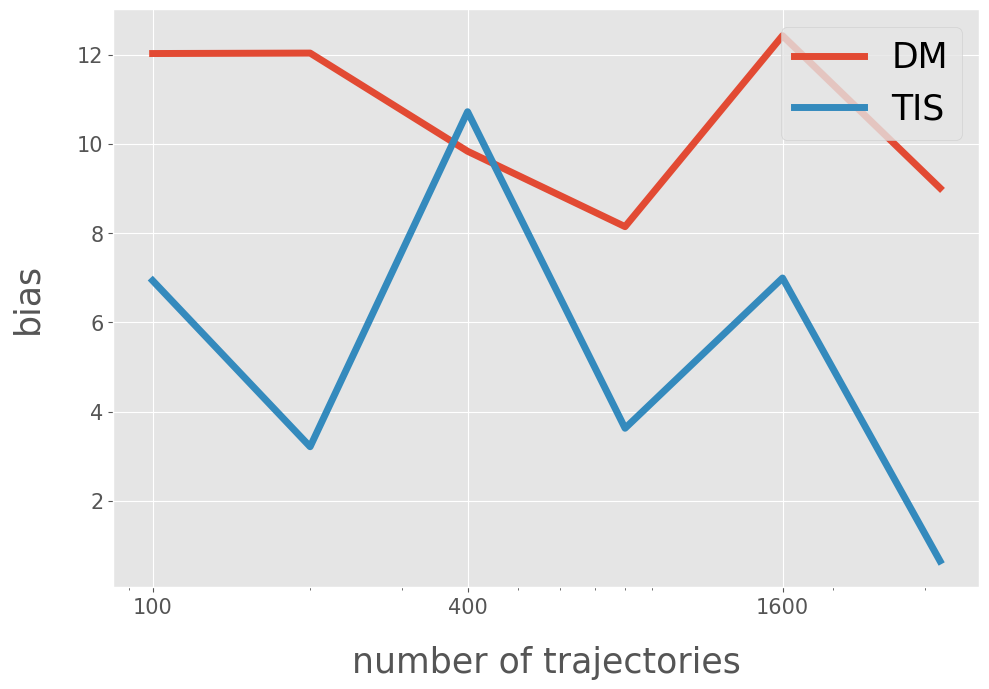

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_77306/132179728.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


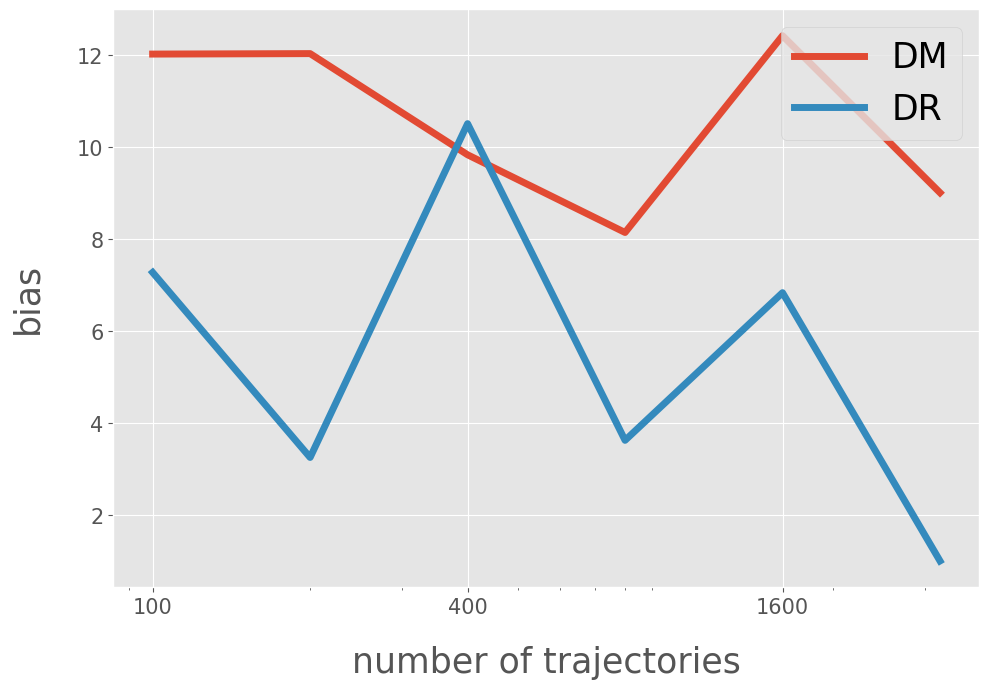

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
variance_result_df

,index,est,variance,n_trajectories
0,on_policy,0,1.745166e+00,100
1,dm,0,3.528258e-02,100
2,tis,0,5.566083e+03,100
3,pdis,0,1.957226e+02,100
4,dr,0,2.101882e+02,100
...,...,...,...,...
97,sam_is,0,8.145950e-08,3200
98,sam_dr,0,7.581411e-02,3200
99,sam_snis,0,3.650961e+01,3200
100,sam_sndr,0,3.593826e+01,3200


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_77306/1079444482.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


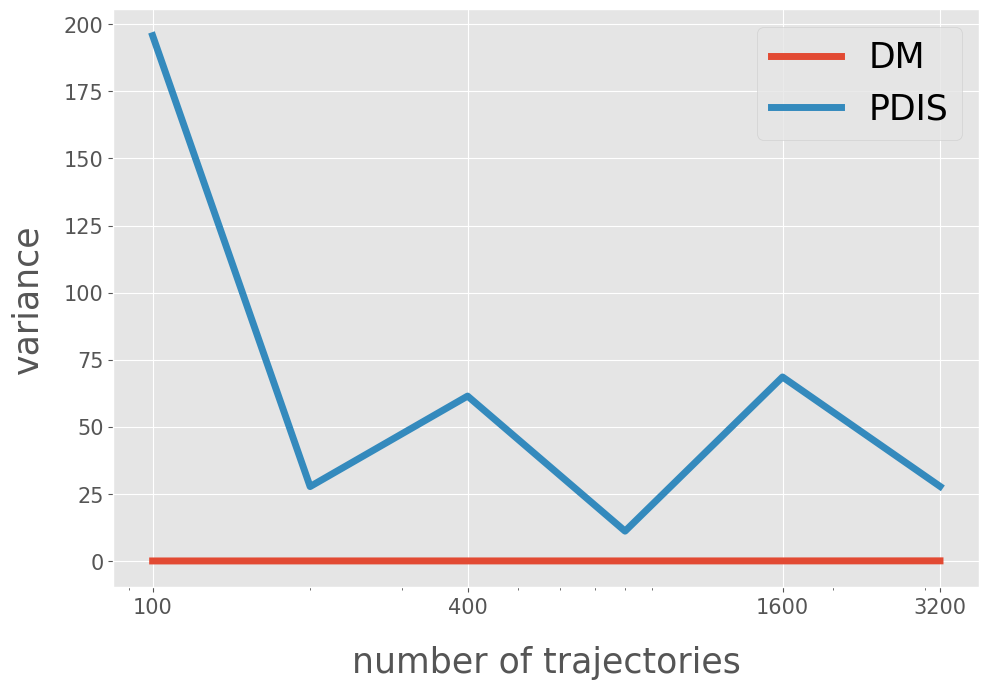

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 3200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_77306/1525150744.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


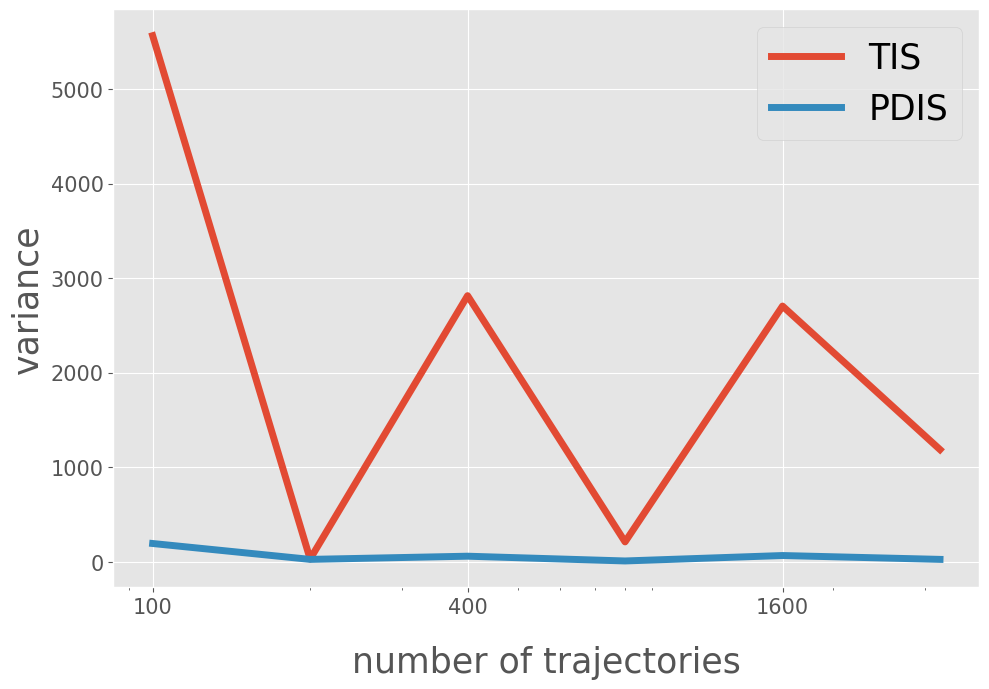

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_77306/3324735909.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


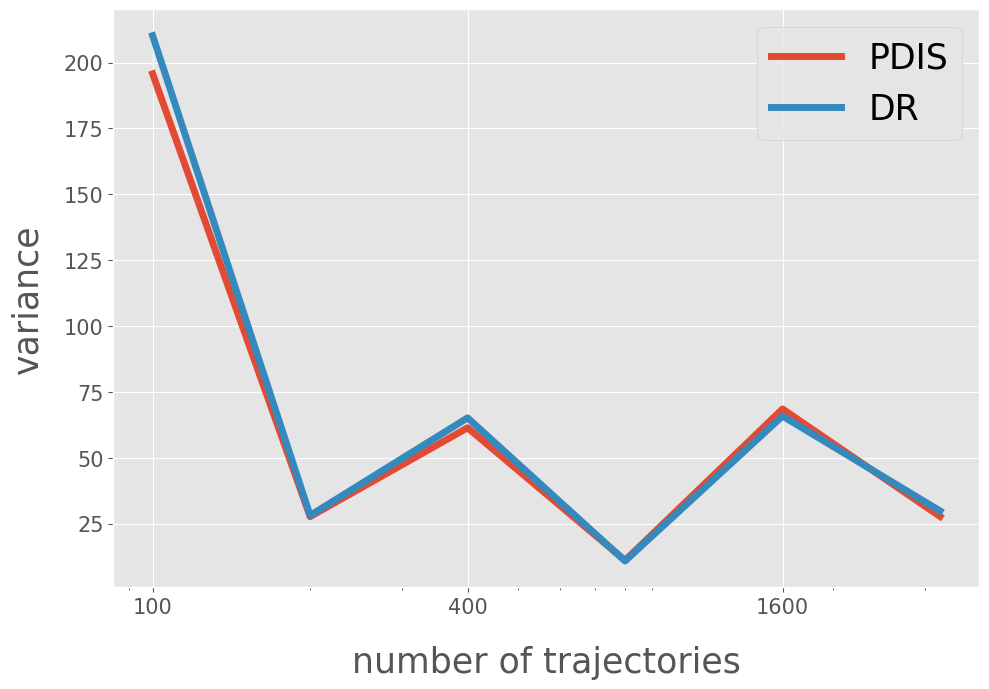

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)